In [1]:
## Figure 06 & Table 01 - Comparing InSAR Time-series with GPS Time-series

import os
import sys
import pickle
import time
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, giantTimeseries
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet
from pysar.utils.insar_vs_gps import insar_vs_gps
from pysar.objects.gps import GPS
from pysar import view

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/insar_vs_gps')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# GPS
site_names = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
gps_dir = os.path.expanduser('~/insarlab/Galapagos/GPS')
ref_site = 'GV01'
gps_loc_file = os.path.join(gps_dir, 'loc.txt')
start_date = '20141101'
end_date = '20180625'

# InSAR
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128')
out_file = 'pysar.pickle'
ts_file       = os.path.join(proj_dir, 'PYSAR/timeseries_ECMWF_ramp_demErr.h5')
geom_file     = os.path.join(proj_dir, 'PYSAR/INPUTS/geometryRadar.h5')
temp_coh_file = os.path.join(proj_dir, 'PYSAR/temporalCoherence.h5')

## PySAR vs GIAnT
#out_file = 'pysar_m.pickle';   ts_file = os.path.join(proj_dir, 'GIANT/PYSAR/timeseries_ECMWF_ramp_demErr.h5')
#out_file = 'g-sbas.pickle';    ts_file = os.path.join(proj_dir, 'GIANT/Stack/LS-PARAMS.h5')
#out_file = 'g-nsbas.pickle';   ts_file = os.path.join(proj_dir, 'GIANT/Stack/NSBAS-PARAMS.h5')
#out_file = 'g-timefun.pickle'; ts_file = os.path.join(proj_dir, 'GIANT/Stack/TS-PARAMS.h5')

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/insar_vs_gps


In [2]:
# Read / Generate and Save data
if not os.path.isfile(out_file):
    obj = insar_vs_gps(ts_file, geom_file, temp_coh_file, site_names, gps_dir, ref_site, gps_loc_file=None)
    obj.open()
    with open(out_file, 'wb') as f:
        pickle.dump(obj.ds, f)
    print('saved to pickle file {}.'.format(out_file))
    ds = dict(obj.ds)
else:
    with open(out_file, 'rb') as f:
        ds = pickle.load(f)
    print('read from pickle file {}.'.format(out_file))

read from pickle file pysar.pickle.


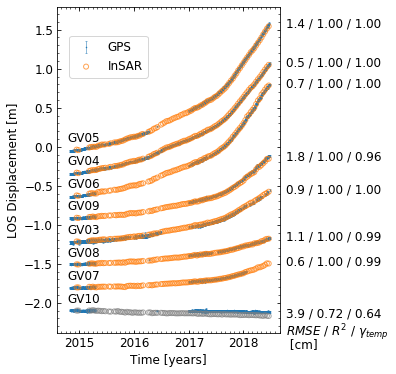

In [5]:
## Figure 6 (b) - Displacement Time-series from InSAR and GPS
fig, ax = plt.subplots(figsize=(4, 6))
site2plot = insar_vs_gps.sort_by_velocity(ds)
for i in range(len(site2plot)):
    site = ds[site2plot[i]]
    ax = insar_vs_gps.plot_one_site(ax, site, offset=0.3*i)

yr_list = [i.year + (i.timetuple().tm_yday - 1)/365.25 for i in site['insar_datetime']]
ax = pp.auto_adjust_xaxis_date(ax, yr_list)[0]
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('LOS Displacement [m]', fontsize=font_size)
ax.annotate(r'$RMSE$ / $R^2$ / $\gamma_{temp}$', xy=(1.03, -0.01), xycoords='axes fraction', fontsize=font_size, color='k')
ax.annotate(' [cm]', xy=(1.03, -0.045), xycoords='axes fraction', fontsize=font_size, color='k')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[-1], handles[0]], ['GPS', 'InSAR'], loc='upper left', bbox_to_anchor=(0.03, 0.93), fontsize=font_size)
plt.savefig('insar_vs_gps_point_ts.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

view.py /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/geo_timeseries_ECMWF_ramp_demErr.h5 20180619 --ref-date 20141213 --dem /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84 --dem-nocontour -m /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/geo_maskTempCoh.h5 --sub-lat -0.86 -0.77 --sub-lon -91.19 -91.07 -u m --vlim -0.4 2.5 --lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 0.2 0.85 0.05 --fontsize 12 --notitle --dpi 600 --cbar-nbins 6 --cbar-ext both --nomultilook --show-gps --gps-comp enu2los --ref-gps GV01 


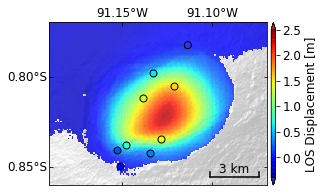

In [8]:
## Figure 6 (a) - InSAR velocity map with GPS location on Sierra Negra
proj_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
vel_file  = os.path.join(proj_dir, 'geo_velocity_masked.h5')
dem_file  = os.path.join(proj_dir, '../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84')
ts_file   = os.path.join(proj_dir, 'geo_timeseries_ECMWF_ramp_demErr.h5')
mask_file = os.path.join(proj_dir, 'geo_maskTempCoh.h5')

print_msg = False
fig, ax = plt.subplots(figsize=(5, 3))
# call view.py functions to plot InSAR background
cmd  = 'view.py {} 20180619 --ref-date 20141213 --dem {} --dem-nocontour -m {} '.format(ts_file, dem_file, mask_file)
cmd += '--sub-lat -0.86 -0.77 --sub-lon -91.19 -91.07 -u m --vlim -0.4 2.5 '
cmd += '--lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 0.2 0.85 0.05 '
cmd += '--fontsize 12 --notitle --dpi 600 '
cmd += '--cbar-nbins 6 --cbar-ext both --nomultilook '
cmd += '--show-gps --gps-comp enu2los --ref-gps GV01 '
print(cmd)
d_v, atr, inps = view.prep_slice(cmd, print_msg=print_msg)
inps.cbar_label = 'LOS Displacement [m]'
ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps, print_msg=print_msg)

plt.savefig('insar_vs_gps_map.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

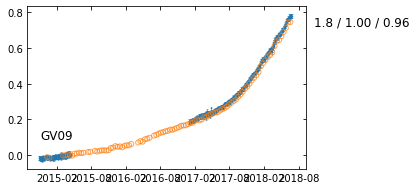

In [5]:
## plot single station timeseries - InSAR vs GPS
site = ds['GV09']
fig, ax = plt.subplots(figsize=(5, 3))
ax = insar_vs_gps.plot_one_site(ax, site, offset=0)
ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
#plt.savefig('{}-{}.jpg'.format(site, ref_site), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

lat/lon: -0.7824/-91.1134, y/x: 1464/466
lat/lon: -0.7978/-91.1329, y/x: 1494/494
lat/lon: -0.8115/-91.1381, y/x: 1517/498
lat/lon: -0.8049/-91.1212, y/x: 1501/472
lat/lon: -0.8343/-91.1281, y/x: 1549/472
lat/lon: -0.8405/-91.1526, y/x: 1566/512
lat/lon: -0.8420/-91.1344, y/x: 1563/481
lat/lon: -0.8373/-91.1474, y/x: 1560/504
lat/lon: -0.8493/-91.1510, y/x: 1579/506


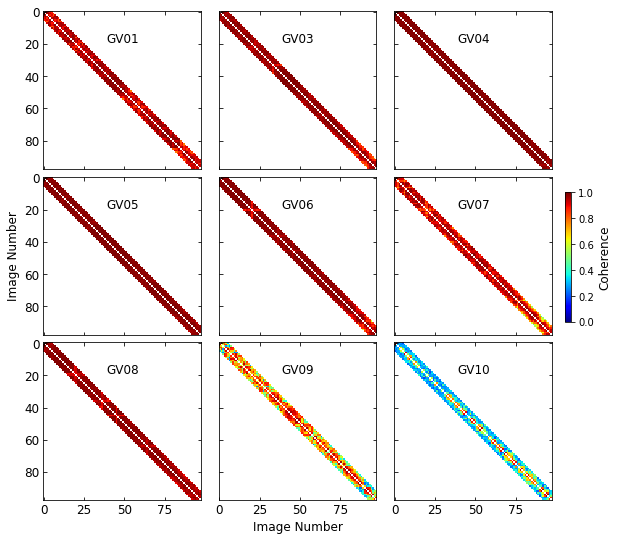

Done.


In [33]:
## Figure S3 - Coherence Matrix of InSAR observation on GPS sites

def get_site_coherence_matrix(site='GV01'):
    gps_obj = gps(site, data_dir=gps_dir)
    gps_obj.open(print_msg=False)

    ifg_file = os.path.join(proj_dir, 'INPUTS/ifgramStack.h5')
    geom_file = os.path.join(proj_dir, 'INPUTS/geometryRadar.h5')
    stack_obj = ifgramStack(ifg_file)
    stack_obj.open(print_msg=False)
    date12_list_all = stack_obj.get_date12_list(dropIfgram=True)

    coord = ut.coordinate(stack_obj.metadata, lookup_file=geom_file)
    y, x = coord.geo2radar(gps_obj.site_lat, gps_obj.site_lon, print_msg=False)[0:2]
    box = (x, y, x+1, y+1)
    dset_list = ['coherence-{}'.format(i) for i in date12_list_all]
    coh = np.squeeze(readfile.read(ifg_file, datasetName=dset_list, box=box, print_msg=False)[0])

    print('lat/lon: {:.4f}/{:.4f}, y/x: {}/{}'.format(gps_obj.site_lat, gps_obj.site_lon, y, x))

    coh_date12_list = list(np.array(date12_list_all)[np.array(coh) >= 0.25])
    date12_to_drop = sorted(list(set(date12_list_all) - set(coh_date12_list)))

    coh_mat = pnet.coherence_matrix(date12_list_all, coh.tolist())

    A = stack_obj.get_design_matrix4timeseries(date12_list = coh_date12_list)[0]
    if np.linalg.matrix_rank(A) < A.shape[1]:
        print('Singular design matrix!')
    return coh_mat

gps_sites = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[9, 9], sharex=True, sharey=True)
for i in range(len(gps_sites)):
    ax = axs.flatten()[i]
    site = gps_sites[i]
    coh_mat = get_site_coherence_matrix(site)
    im = ax.imshow(coh_mat, cmap='jet', vmin=0., vmax=1.)
    ax.tick_params(which='both', direction='in', labelsize=font_size,
                   bottom=True, top=True, left=True, right=True)
    ax.annotate(site, xy=(0.4, 0.8), color='k', xycoords='axes fraction', fontsize=font_size)
axs[1,0].set_ylabel('Image Number', fontsize=font_size)
axs[2,1].set_xlabel('Image Number', fontsize=font_size)

# colorbar
fig.subplots_adjust(right=0.93)
cax = fig.add_axes([0.94, 0.4, 0.01, 0.2])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Coherence', fontsize=font_size)

fig.subplots_adjust(wspace=0.03, hspace=0.05)
plt.savefig('insar_vs_gps_coh_mat.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()
print('Done.')

In [ ]:
## Table 1 - RMSE of InSAR relative to GPS
##----------PySAR Pmask G-SBAS G-NSBAS G-TimeFun
GV01, rmse: 0.0,  0.0,   0.0,   0.0,    0.0 cm, r_square: 0.00, temp_coh: 0.99
GV03, rmse: 0.9,  0.9,   0.7,   0.7,    0.7 cm, r_square: 1.00, temp_coh: 1.00
GV04, rmse: 0.5,  0.5,   0.4,   0.4,    0.4 cm, r_square: 1.00, temp_coh: 1.00
GV05, rmse: 1.4,  1.4,   1.6,   1.6,    1.5 cm, r_square: 1.00, temp_coh: 1.00
GV06, rmse: 0.7,  0.7,   0.6,   0.6,    0.6 cm, r_square: 1.00, temp_coh: 1.00
GV07, rmse: 0.6,  0.6,   0.5,   0.5,    0.6 cm, r_square: 1.00, temp_coh: 0.99
GV08, rmse: 1.1,  1.0,   1.1,   1.1,    1.1 cm, r_square: 1.00, temp_coh: 0.99
GV09, rmse: 1.8,  1.8,   nan,   2.3,    nan cm, r_square: 1.00, temp_coh: 0.96
GV10, rmse: 3.9,  4.0,   nan,   2.7,    nan cm, r_square: 0.72, temp_coh: 0.64

In [6]:
## Stats
insar_vs_gps.print_stats(ds)

GV01, rmse: 0.0 cm, r_square: 0.00, temp_coh: 0.99
GV03, rmse: 0.9 cm, r_square: 1.00, temp_coh: 1.00
GV04, rmse: 0.5 cm, r_square: 1.00, temp_coh: 1.00
GV05, rmse: 1.4 cm, r_square: 1.00, temp_coh: 1.00
GV06, rmse: 0.7 cm, r_square: 1.00, temp_coh: 1.00
GV07, rmse: 0.6 cm, r_square: 1.00, temp_coh: 0.99
GV08, rmse: 1.0 cm, r_square: 1.00, temp_coh: 0.99
GV09, rmse: 1.8 cm, r_square: 1.00, temp_coh: 0.96
GV10, rmse: 4.0 cm, r_square: 0.72, temp_coh: 0.64
